In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

In [4]:
train_dir = "/kaggle/input/jellyfish-types/Train_Test_Valid/Train"
test_dir = "/kaggle/input/jellyfish-types/Train_Test_Valid/test"
val_dir = "/kaggle/input/jellyfish-types/Train_Test_Valid/valid"

In [1]:
import torchvision
pretrained_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

In [2]:
image_transforms = pretrained_weights.transforms()
print(image_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [5]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()

train_data = datasets.ImageFolder(train_dir, transform = image_transforms)
val_data = datasets.ImageFolder(val_dir, transform = image_transforms)
test_data = datasets.ImageFolder(test_dir, transform = image_transforms)

class_names = train_data.classes

In [5]:
id2label = {id:label for id, label in enumerate(train_data.classes)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'Moon_jellyfish',
 1: 'barrel_jellyfish',
 2: 'blue_jellyfish',
 3: 'compass_jellyfish',
 4: 'lions_mane_jellyfish',
 5: 'mauve_stinger_jellyfish'}

In [6]:

train_dataloader = DataLoader(train_data,
                                batch_size = BATCH_SIZE,
                                shuffle = True,
                                num_workers = NUM_WORKERS)
val_dataloader = DataLoader(test_data,
                        batch_size = BATCH_SIZE,
                        num_workers = NUM_WORKERS)

test_dataloader = DataLoader(test_data,
                            batch_size = BATCH_SIZE,
                            num_workers = NUM_WORKERS)

torch.Size([3, 224, 224]) tensor(5)


(-0.5, 223.5, 223.5, -0.5)

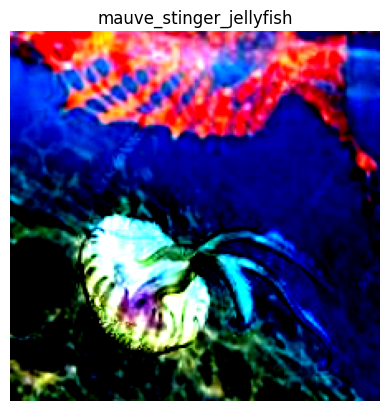

In [9]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

print(image.shape, label)

plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [10]:

pretrained_vit = torchvision.models.vit_b_16(weights = pretrained_weights)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

pretrained_vit.heads = nn.Linear(in_features= 768, out_features= len(class_names))

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 152MB/s]  


In [11]:
from torchinfo import summary
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 6]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [12]:
import torch
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [22]:
from tqdm import tqdm
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [23]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device):
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


In [24]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device):
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [25]:
Epochs = 10
train(model=pretrained_vit,train_dataloader=train_dataloader,test_dataloader=test_dataloader,optimizer=optimizer,loss_fn=loss_fn,epochs=20,device=device)

  5%|▌         | 1/20 [00:23<07:24, 23.39s/it]

Epoch: 1 | train_loss: 1.2794 | train_acc: 0.6382 | test_loss: 0.8884 | test_acc: 0.8333


 10%|█         | 2/20 [00:47<07:11, 23.97s/it]

Epoch: 2 | train_loss: 0.7047 | train_acc: 0.8618 | test_loss: 0.7021 | test_acc: 0.7917


 15%|█▌        | 3/20 [01:12<06:54, 24.40s/it]

Epoch: 3 | train_loss: 0.5006 | train_acc: 0.9189 | test_loss: 0.5095 | test_acc: 0.8958


 20%|██        | 4/20 [01:36<06:27, 24.23s/it]

Epoch: 4 | train_loss: 0.3791 | train_acc: 0.9474 | test_loss: 0.4554 | test_acc: 0.8958


 25%|██▌       | 5/20 [02:00<06:02, 24.18s/it]

Epoch: 5 | train_loss: 0.3070 | train_acc: 0.9627 | test_loss: 0.4309 | test_acc: 0.8750


 30%|███       | 6/20 [02:25<05:40, 24.29s/it]

Epoch: 6 | train_loss: 0.2537 | train_acc: 0.9605 | test_loss: 0.3993 | test_acc: 0.8750


 35%|███▌      | 7/20 [02:49<05:15, 24.28s/it]

Epoch: 7 | train_loss: 0.2189 | train_acc: 0.9704 | test_loss: 0.3547 | test_acc: 0.8958


 40%|████      | 8/20 [03:13<04:50, 24.25s/it]

Epoch: 8 | train_loss: 0.1898 | train_acc: 0.9803 | test_loss: 0.3416 | test_acc: 0.8958


 45%|████▌     | 9/20 [03:37<04:26, 24.25s/it]

Epoch: 9 | train_loss: 0.1693 | train_acc: 0.9803 | test_loss: 0.3417 | test_acc: 0.8750


 50%|█████     | 10/20 [04:02<04:02, 24.28s/it]

Epoch: 10 | train_loss: 0.1494 | train_acc: 0.9814 | test_loss: 0.3190 | test_acc: 0.9167


 55%|█████▌    | 11/20 [04:26<03:38, 24.31s/it]

Epoch: 11 | train_loss: 0.1329 | train_acc: 0.9890 | test_loss: 0.3078 | test_acc: 0.9375


 60%|██████    | 12/20 [04:51<03:14, 24.32s/it]

Epoch: 12 | train_loss: 0.1210 | train_acc: 0.9901 | test_loss: 0.2960 | test_acc: 0.8958


 65%|██████▌   | 13/20 [05:15<02:50, 24.31s/it]

Epoch: 13 | train_loss: 0.1106 | train_acc: 0.9901 | test_loss: 0.2916 | test_acc: 0.9375


 70%|███████   | 14/20 [05:39<02:25, 24.30s/it]

Epoch: 14 | train_loss: 0.1009 | train_acc: 0.9912 | test_loss: 0.2918 | test_acc: 0.8958


 75%|███████▌  | 15/20 [06:03<02:01, 24.28s/it]

Epoch: 15 | train_loss: 0.0914 | train_acc: 0.9967 | test_loss: 0.2998 | test_acc: 0.9375


 80%|████████  | 16/20 [06:28<01:37, 24.28s/it]

Epoch: 16 | train_loss: 0.0850 | train_acc: 0.9956 | test_loss: 0.3069 | test_acc: 0.9167


 85%|████████▌ | 17/20 [06:52<01:12, 24.27s/it]

Epoch: 17 | train_loss: 0.0790 | train_acc: 0.9956 | test_loss: 0.2953 | test_acc: 0.9167


 90%|█████████ | 18/20 [07:16<00:48, 24.27s/it]

Epoch: 18 | train_loss: 0.0720 | train_acc: 0.9978 | test_loss: 0.2742 | test_acc: 0.9167


 95%|█████████▌| 19/20 [07:40<00:24, 24.26s/it]

Epoch: 19 | train_loss: 0.0672 | train_acc: 0.9989 | test_loss: 0.2960 | test_acc: 0.9167


100%|██████████| 20/20 [08:05<00:00, 24.26s/it]

Epoch: 20 | train_loss: 0.0625 | train_acc: 0.9989 | test_loss: 0.2960 | test_acc: 0.9167


{'train_loss': [1.2794003664401539,
  0.7047416473689833,
  0.5005555521500739,
  0.37914634090766575,
  0.3070198817734133,
  0.25365065391126435,
  0.21888381478033567,
  0.18979319766686673,
  0.1692577709623596,
  0.14936434555994837,
  0.13290200990281606,
  0.12102637256969485,
  0.11061394279986098,
  0.10087071852595136,
  0.09138727521425799,
  0.08501804812827654,
  0.079030940113099,
  0.07204272774489302,
  0.06722208707217585,
  0.06246627154841758],
 'train_acc': [0.6381578947368421,
  0.8618421052631579,
  0.918859649122807,
  0.9473684210526315,
  0.9627192982456141,
  0.9605263157894737,
  0.9703947368421053,
  0.9802631578947368,
  0.9802631578947368,
  0.981359649122807,
  0.9890350877192983,
  0.9901315789473685,
  0.9901315789473685,
  0.9912280701754386,
  0.9967105263157895,
  0.9956140350877193,
  0.9956140350877193,
  0.9978070175438597,
  0.9989035087719298,
  0.9989035087719298],
 'test_loss': [0.8883859316507975,
  0.7021346191565195,
  0.5094907283782959,
 